# Bayesian inference

In [1]:
import sys, os
import logging
import numpy as np
from scipy.stats import uniform, norm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../")
from simulation.prior import get_grid
from inference.bayes import Posterior
import paper_settings

In [2]:
paper_settings.setup()

## Setup

In [3]:
n = 20
n_events_for_expectation = 10000

In [4]:
filename = "alices_full"

In [5]:
def narrow_prior(thetas):
    f_sub = thetas[:,0]
    beta = thetas[:,1]
    
    return uniform(0.001, 0.199).pdf(f_sub).flatten() * norm(-1.9, 0.1).pdf(beta).flatten()

In [6]:
def flat_prior(thetas):
    f_sub = thetas[:,0]
    beta = thetas[:,1]
    
    return uniform(0.001, 0.199).pdf(f_sub).flatten() * uniform(-2.5, 1.0).pdf(beta).flatten()

## Data

In [7]:
llr = np.load("../data/results/llr_{}_grid.npy".format(filename))[:,:n_events_for_expectation]

In [8]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Calculate posteriors

In [9]:
bayes = Posterior(llr, theta_grid)
posterior_narrow = bayes.posterior_based_on_expected_llr(n, narrow_prior)
posterior_flat = bayes.posterior_based_on_expected_llr(n, flat_prior)

## Calculate threshold for credible intervals

In [10]:
def find_ci_threshold(posterior, ci=0.95):
    post_sorted = sorted(posterior.flatten(), reverse=True)
    cumsum = np.cumsum(post_sorted)
    print(cumsum[-1])
    index = np.argmax(cumsum > ci)
    return post_sorted[index]

In [11]:
threshold_flat = find_ci_threshold(posterior_flat)
threshold_narrow = find_ci_threshold(posterior_narrow)

1.0000000002618565
0.9999999986081125


## Plot posterior

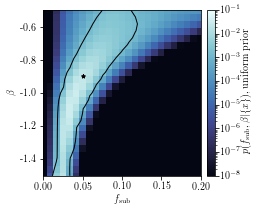

In [27]:
pmin, pmax = 1.e-8, 0.1
z = np.clip(posterior_flat, pmin, pmax)

fig, (ax, cax) = paper_settings.figure(
    cbar=True,
)
plt.sca(ax)

pcm = ax.pcolormesh(
    alpha_edges,
    beta_edges,
    z.reshape((resolution, resolution)),
    norm=matplotlib.colors.LogNorm(vmin=pmin, vmax=pmax),
    cmap=paper_settings.CMAP2
)
cs = ax.contour(
    0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
    0.5 * (beta_edges[1:] + beta_edges[:-1]),
    z.reshape((resolution, resolution)),
    [threshold_flat],
    colors="black",
    linewidths=1.,
    linestyles=["-"],
)
ax.scatter(0.05, -1.9, s=15., color='black', marker='*')

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$\beta$')
plt.xlim(0.,0.2)
plt.ylim(-2.5,-1.5) 
plt.xticks([0.,0.05,0.1,0.15,0.2])
plt.yticks([-1.6,-1.8,-2.0,-2.2,-2.4],["-0.6", "-0.8", "-1.0", "-1.2", "-1.4"])
 
cbar = fig.colorbar(
    pcm,
    cax=cax,
    #ticks=[0.,1.,2.,3.,4.,5.],
    #format=matplotlib.ticker.FuncFormatter(lambda x, _ : "{:.0f}".format(x**2))
)
cbar.set_label(r'$p(f_{\mathrm{sub}}, \beta | \{x\})$, uniform prior')
cax.yaxis.set_label_coords(4.3, 0.5)
cax.yaxis.set_tick_params(pad=1)
    
plt.savefig("../figures/posterior_uniform.pdf")


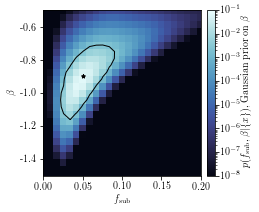

In [28]:
pmin, pmax =1.e-8, 0.1
z = np.clip(posterior_narrow, pmin, pmax)

fig, (ax, cax) = paper_settings.figure(
    cbar=True,
)
plt.sca(ax)

pcm = ax.pcolormesh(
    alpha_edges,
    beta_edges,
    z.reshape((resolution, resolution)),
    norm=matplotlib.colors.LogNorm(vmin=pmin, vmax=pmax),
    cmap=paper_settings.CMAP2
)
cs = ax.contour(
    0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
    0.5 * (beta_edges[1:] + beta_edges[:-1]),
    z.reshape((resolution, resolution)),
    [threshold_narrow],
    colors="black",
    linewidths=1.,
    linestyles=["-"],
)
ax.scatter(0.05, -1.9, s=15., color='black', marker='*')

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$\beta$')
plt.xlim(0.,0.2)
plt.ylim(-2.5,-1.5) 
plt.xticks([0.,0.05,0.1,0.15,0.2])
plt.yticks([-1.6,-1.8,-2.0,-2.2,-2.4],["-0.6", "-0.8", "-1.0", "-1.2", "-1.4"])
 
cbar = fig.colorbar(
    pcm,
    cax=cax,
    #ticks=[0.001,0.003,0.01,0.03],
    #format=matplotlib.ticker.FuncFormatter(lambda x, _ : "{:.0f}".format(x**2))
)
cbar.set_label(r'$p(f_{\mathrm{sub}}, \beta | \{x\})$, Gaussian prior on $\beta$')
cax.yaxis.set_label_coords(4.3, 0.5)
cax.yaxis.set_tick_params(pad=1)
    
plt.savefig("../figures/posterior_narrow.pdf")


# Below here not updated! There be dragons

## 1D projections

In [51]:
def project(posterior):
    return np.sum(posterior.reshape((25,25)), axis=0)

In [52]:
posteriors_1d = [project(posterior) for posterior in posteriors]
posteriors_1d_flatprior = [project(posterior) for posterior in posteriors_flatprior]

In [61]:
def prep(edges, histo):
    edges_ = np.copy(edges)
    histo_ = np.copy(histo)
    edges_ = np.repeat(edges_, 2)[1:-1]
    histo_ = np.repeat(histo_, 2)
    return edges_, histo_


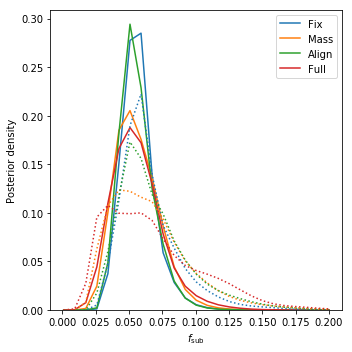

In [63]:
fig = plt.figure(figsize=(5,5))

for i, (posterior, label) in enumerate(zip(posteriors_1d, labels)):
    plt.plot(f_sub_1d, posterior, ls="-", label=label, c="C{}".format(i))

for i, (posterior, label) in enumerate(zip(posteriors_1d_flatprior, labels)):
    plt.plot(f_sub_1d, posterior, ls=":", c="C{}".format(i))
    
plt.legend()

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel("Posterior density")
#plt.yscale("log")
plt.ylim(0., None)

plt.tight_layout()
plt.savefig("../figures/posterior_1d.pdf")


## Check integral over posterior

In [64]:
for posteriors_ in [posteriors, posteriors_flatprior, posteriors_1d, posteriors_1d_flatprior]:
    for posterior in posteriors_:
        print(np.sum(posterior))
    print("")

0.9999999971562625
0.9999999996837958
0.9999999997503995
0.9999999998882961

0.9999999987547427
1.0000000000943188
1.0000000007021506
0.9999999998595811

0.9999999971562625
0.9999999996837959
0.9999999997503994
0.999999999888296

0.9999999987547428
1.0000000000943188
1.0000000007021506
0.9999999998595813

